# Предвзятость алгоритма ранжирования товаров Ozon - ML-подход

В [наивном подходе](https://github.com/Seiron/coursework/blob/main/naiive_analysis.ipynb) предполагается, что лишь одна прокси-переменная определяет логику ранжирования товаров в поисковой выдаче, что позволяло использовать меньше информации при оценке предвзятости. Но, во-первых, очевидно, что на алгоритм ранжирования будут влиять и отзывы, и участие в распродажах, и прочие параметры. Во-вторых, наивный подход не сможет засечь небольшую предвзятость в ранжировании. В таком случае логичнее попытаться воссоздать алгоритм ранжирования товаров Ozon на основе всех существенных параметров. Поэтому в данном ноутбуке 2 задачи:

1. Подтвердить результаты наивного подхода
2. Оценить, насколько точнее работает подход на основе методов машинного обучения

### Загрузка необходимых библиотек и данных

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, ndcg_score
pd.options.mode.chained_assignment = None

В качестве датасета снова используем датасет [algo_data.csv](https://github.com/Seiron/coursework/blob/main/algo_data.csv), представляющий собой данные, полученные автором путем парсинга поисковой выдачи сайта Ozon по ряду неспецифических запросов ("query" в датасете), соединенные с данными с сервиса Ozon.Data

In [3]:
data = pd.read_csv("algo_data.csv")

In [4]:
label_encoder = LabelEncoder()
data['Схема работы'] = label_encoder.fit_transform(data['Схема работы'])
data['query'] = label_encoder.fit_transform(data['query'])
data['Super-товар'] = label_encoder.fit_transform(data['Super-товар'])
data['price'] = (data["price"])

ozon_data = data[data['sellers'].str.contains('OZON', na=False)]
inference_data = data.drop(["url","sellers","rank",'product_name'], axis=1)


Общая логика подхода следующая: обучим модель на данных о ранжировании товаров Ozon. Если взять алгоритм ранжирования товаров Ozon как эталонный, то, в случае отсутствия предвзятости алгоритма к товарам сторонних продавцов, отклонения от реальных рангов товаров, если они будут, должны не сильно отличаться для товаров сторонних продавцов и товаров Ozon. Выберем 5 запросов, на которых модель будет обучаться и 1 запрос оставим для инференса (в инференс включаем и товары Ozon, и товары сторонних продавцов по запросу №6)

In [5]:
query_values = [0, 1,2, 3, 4]
ozon_data = ozon_data[ozon_data["query"].isin(query_values)]
qid = ozon_data["query"]
X = ozon_data.drop(["url","sellers","rank",'product_name'], axis=1)
X = X.sort_values(by='query')
y = ozon_data.groupby('query').cumcount()
inference_data = data.drop(["url","sellers","rank",'product_name'], axis=1)

Оптимизируем по метрике $NDCG@k = \frac {DCG@k} {IDCG@k}$,      
где     
$DCG@k=\sum_{i=1}^k\frac {rel_i} {log_2(i+1)}$    

$IDCG@k - Ideal DCG$

In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

num_boost_round = 100

param_grid = {
    'max_depth': np.linspace(1, 10, 10, dtype=int),
    'min_child_weight': np.linspace(0.1, 10, 5, dtype=int),
    'subsample': np.linspace(0.1, 1.0, 5),
    'colsample_bytree': np.linspace(0.1, 1.0, 5),
    'eta': [1e-4,1e-3, 1e-2]
}


xgb_model = xgb.XGBRegressor(objective='rank:ndcg', eval_metric='ndcg', ndcg_exp_gain=False)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)

best_params = grid_search.best_params_
best_xgb_model = xgb.XGBRegressor(objective='rank:ndcg', eval_metric='ndcg', ndcg_exp_gain=False, **best_params)

best_xgb_model.fit(X_train, y_train)

predictions = best_xgb_model.predict(X_test)

y_test_array = y_test.to_numpy()
predictions_array = predictions

predicted_ranks = np.argsort(-predictions)

ndcg = ndcg_score([y_test], [predicted_ranks])
print(f'Normalized Discounted Cumulative Gain (NDCG): {ndcg}')

def get_top_n_recommendations(data, n=5):
    data['prediction'] = best_xgb_model.predict(data)
    top_n_items = data.sort_values(by='prediction', ascending=True).head(n)
    return top_n_items

Fitting 10 folds for each of 3750 candidates, totalling 37500 fits
Best parameters:  {'colsample_bytree': 0.1, 'eta': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'subsample': 0.325}
Normalized Discounted Cumulative Gain (NDCG): 0.7853620222938447


Результаты достаточно хорошие. Хотелось бы сделать тренировочный сет больше, но есть ограничения по времени парсинга информации + факт неточного совпадения с данными Ozon.Data из-за постоянно меняющихся url карточек товаров

In [7]:
"""import lightgbm as lgb
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
X = ozon_data.drop(["url","sellers","rank",'product_name','query'], axis=1)

params = {
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'num_leaves': 31,
    'learning_rate': 0.001,
    'feature_fraction': 0.09,
    'bagging_fraction': 0.8,
    'bagging_freq': 50,
    'verbose': 0,
    'label_gain': np.arange(2400)
}

X_train, X_val, y_train, y_val, qid_train, qid_val = train_test_split(X, y, qid, test_size=0.1, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train, group=np.array([185,108,40,26,15,5]))
val_data = lgb.Dataset(X_val, label=y_val, group=np.array([19, 14, 4, 3, 2, 1]))

num_round = 10000
bst = lgb.train(params, train_data, num_round, valid_sets=[val_data])

# Predict on test set
y_pred = bst.predict(X_val)

# Evaluate the model using NDCG
predicted_ranks = np.argsort(-y_pred)

ndcg = ndcg_score([y_val], [predicted_ranks])
print("NDCG Score on Test Set:", ndcg)

def get_top_n_recommendations(data, n=5):
    data['prediction'] = bst.predict(data, predict_disable_shape_check=True)
    top_n_items = data.sort_values(by='prediction', ascending=True).head(n)
    return top_n_items"""

'import lightgbm as lgb\nfrom sklearn.datasets import load_svmlight_file\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import ndcg_score\nX = ozon_data.drop(["url","sellers","rank",\'product_name\',\'query\'], axis=1)\n\nparams = {\n    \'boosting_type\': \'gbdt\',\n    \'objective\': \'lambdarank\',\n    \'metric\': \'ndcg\',\n    \'num_leaves\': 31,\n    \'learning_rate\': 0.001,\n    \'feature_fraction\': 0.09,\n    \'bagging_fraction\': 0.8,\n    \'bagging_freq\': 50,\n    \'verbose\': 0,\n    \'label_gain\': np.arange(2400)\n}\n\nX_train, X_val, y_train, y_val, qid_train, qid_val = train_test_split(X, y, qid, test_size=0.1, random_state=42)\n\ntrain_data = lgb.Dataset(X_train, label=y_train, group=np.array([185,108,40,26,15,5]))\nval_data = lgb.Dataset(X_val, label=y_val, group=np.array([19, 14, 4, 3, 2, 1]))\n\nnum_round = 10000\nbst = lgb.train(params, train_data, num_round, valid_sets=[val_data])\n\n# Predict on test set\ny_pred = bst.predict(X_val

(Альтернативно можно использовать LambdaMART, но результаты оказались хуже)

Теперь предскажем ранги как для товаров Ozon, так и для товаров сторонних продавцов

In [8]:
top_recommendations = get_top_n_recommendations(inference_data[inference_data["query"].isin([5])], n=10000)

In [20]:
top_recommendations['recom_rank'] = top_recommendations['prediction'].rank(method='first', ascending=True)
check = pd.merge(top_recommendations, data)
check["rank_diff"] = -check["recom_rank"] + check["rank"]
check_ozon = check[check['sellers'].str.contains('OZON', na=False)]
check_3p = check[~check['sellers'].str.contains('OZON', na=False)]


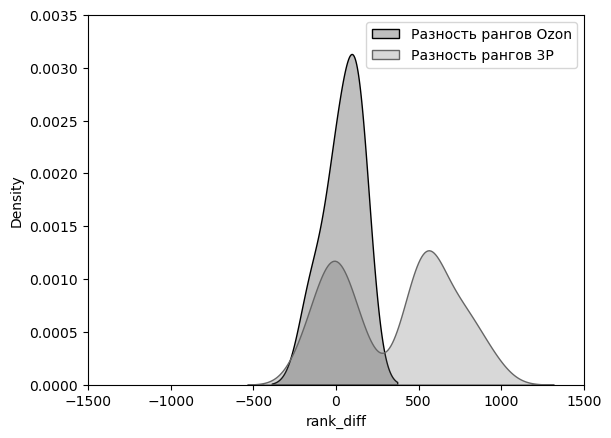

In [21]:
sns.kdeplot(check_ozon['rank_diff'], fill=True, label='Разность рангов Ozon', color=(0,0,0))
sns.kdeplot(check_3p['rank_diff'], fill=True, label='Разность рангов 3P', color=(0.4,0.4,0.4))

plt.legend()
plt.xlim(left=-1500,right=1500)
plt.ylim(top=0.0035)

plt.show()

Из графика уже становится очевидно, что отклонения для товаров из двух групп распределены не одинаково, при этом отклонения рангов для товаров Ozon в среднем находятся где-то в районе нуля, тогда как для товаров сторонних продавцов - значительно правее

In [22]:
print(check_ozon["rank_diff"].mean())
print(check_3p["rank_diff"].mean())

39.666666666666664
352.6109785202864


Проведем формальные тесты, но для начала проверим, можно ли использовать t-тест:

In [24]:
statistic_ozon, p_value_ozon = stats.shapiro(check_ozon["rank_diff"])
statistic_3p, p_value_3p = stats.shapiro(check_3p["rank_diff"])

print("Ozon - Статистика:", statistic_ozon,", P-значение:", p_value_ozon )
print("3P - Статистика:", statistic_3p, ", P-значение:", p_value_3p)

Ozon - Статистика: 0.8396639823913574 , P-значение: 0.12953169643878937
3P - Статистика: 0.9176534414291382 , P-значение: 2.3237264705749244e-14


Лучше использовать тест критерий Уилкоксона:

In [26]:
stat_ozon, p_value_ozon = stats.wilcoxon(check_ozon['rank_diff'], alternative='two-sided')
stat_3p, p_value_3p = stats.wilcoxon(check_3p["rank_diff"], alternative='greater')
print("Ozon - Статистика Уилкоксона:", stat_ozon, ", p-значение:", p_value_ozon)
print("3P - Статистика Уилкоксона:", stat_3p, ", p-значение:", p_value_3p)

Ozon - Статистика Уилкоксона: 7.0 , p-значение: 0.5625
3P - Статистика Уилкоксона: 78446.0 , p-значение: 3.6525283997144305e-44


Итак, на любом разумном уровне значимости среднее отклонение предсказанных рангов от реальных рангов:   
* Для товаров Ozon не отличается от 0    
* Для товаров сторонних продавцов больше 0

При использовании данного метода уверенность в результатах значительно выше, чем в случае использования наивного подхода, что не удивительно
Существует статистически значимое занижение в поисковой выдаче товаров сторонних продавцов. Стоит ли беспокоиться? Сторонним продавцам - да. Но, согласно теоретико-игровой модели, разработанной в [моей работе](https://github.com/Seiron/coursework/edit/main/vkr.pdf), использование недобросовестных практик приводит к увеличению общесивенного благосостояния. 



In [30]:
check_ozon = check_ozon[check_ozon["price"].notna()]
check_3p = check_3p[check_3p["price"].notna()]
ozon_mean = check_ozon[['price', 'rating', 'num_ratings', 'black_friday', 'query',
       'Super-товар', 'Доступность (%)',
       'Количество складов отгрузки (шт.)', 'Доля рекламных расходов (%)',
       'Продажи 28 дней']].mean()
third_party_mean = check_3p[['price', 'rating', 'num_ratings', 'black_friday', 'query',
       'Super-товар', 'Доступность (%)',
       'Количество складов отгрузки (шт.)', 'Доля рекламных расходов (%)',
       'Продажи 28 дней']].mean()


In [31]:
pd.options.display.float_format = '{:.2f}'.format

print(ozon_mean)
print(third_party_mean)

price                               2947.80
rating                                 4.84
num_ratings                           51.40
black_friday                           1.00
query                                  5.00
Super-товар                            0.20
Доступность (%)                        1.00
Количество складов отгрузки (шт.)     10.80
Доля рекламных расходов (%)            0.00
Продажи 28 дней                     2851.05
dtype: float64
price                               2018.80
rating                                 4.80
num_ratings                          275.89
black_friday                           0.42
query                                  5.00
Super-товар                            0.15
Доступность (%)                        0.92
Количество складов отгрузки (шт.)     12.52
Доля рекламных расходов (%)            0.04
Продажи 28 дней                     2642.54
dtype: float64


In [34]:
columns_to_test = ['price', 'rating', 'num_ratings', 'black_friday', 'query',
       'Super-товар', 'Доступность (%)',
       'Количество складов отгрузки (шт.)', 'Доля рекламных расходов (%)',
       'Продажи 28 дней']
for column in columns_to_test:
    statistic, p_value = stats.mannwhitneyu(check_3p[check_3p.notna()][column], check_ozon[check_ozon.notna()][column])
    
    # Печать результатов
    print("Столбец:", column)
    print("t-статистика:", statistic)
    print("p-значение:", p_value)
    if p_value < 0.05:
        print("Различие средних значений статистически значимо на 5% уровне значимости","\n")
    else:
        print("Нет статистически значимого различия средних значений на 5% уровне значимости","\n")

Столбец: price
t-статистика: 857.0
p-значение: 0.49018546105753047
Нет статистически значимого различия средних значений на 5% уровне значимости 

Столбец: rating
t-статистика: 944.5
p-значение: 0.6886304114847537
Нет статистически значимого различия средних значений на 5% уровне значимости 

Столбец: num_ratings
t-статистика: 1568.5
p-значение: 0.05422101245538759
Нет статистически значимого различия средних значений на 5% уровне значимости 

Столбец: black_friday
t-статистика: 440.0
p-значение: 0.009438545030404259
Различие средних значений статистически значимо на 5% уровне значимости 

Столбец: query
t-статистика: 1045.0
p-значение: 1.0
Нет статистически значимого различия средних значений на 5% уровне значимости 

Столбец: Super-товар
t-статистика: 988.5
p-значение: 0.7365717770148912
Нет статистически значимого различия средних значений на 5% уровне значимости 

Столбец: Доступность (%)
t-статистика: 740.0
p-значение: 0.16113127399597038
Нет статистически значимого различия средн